<a href="https://colab.research.google.com/github/kateh321/Mathproject/blob/main/VVG16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.transform import resize
get_ipython().run_line_magic('matplotlib', 'inline')
################################################################################
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
################################################################################
from keras import layers,utils
from keras.datasets import cifar100
from keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten,Conv2D,MaxPooling2D, MaxPool2D,Add, concatenate
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input
from keras.applications.vgg16 import VGG16

################################################################################

In [2]:
#Pull dataset from mendeley website
!wget -O PBC_dataset_normal_DIB.zip https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded

--2022-05-01 19:30:07--  https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/5a5a3b1a-0b1d-46bc-bff2-0420599d351b [following]
--2022-05-01 19:30:08--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/5a5a3b1a-0b1d-46bc-bff2-0420599d351b
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.62.120
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.62.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 281366219 (268M) [applicati

In [3]:
#Unzip data
!unzip "/content/PBC_dataset_normal_DIB.zip" 

Streaming output truncated to the last 5000 lines.
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_292483.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_935950.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_890863.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_519370.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_215077.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_388154.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_968896.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_34345.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_349907.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_245683.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_785122.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_615525.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_714613.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_904757.jpg  
  inflating: PBC_dataset_n

In [4]:
#Install split-folders -must do for google collab!
!pip install split-folders

In [5]:
import splitfolders
#Split data into train/val/test
splitfolders.ratio('PBC_dataset_normal_DIB', output="PBC_dataset_normal_DIB_pre", seed=777, ratio=(.70, .15, .15)) 

Copying files: 17092 files [00:02, 5718.22 files/s]


In [6]:
#paths for folders
data_path = 'PBC_dataset_normal_DIB_pre'
print("The Folders in Data Directory is:  ",os.listdir(data_path))

The Folders in Data Directory is:   ['train', 'test', 'val']


In [7]:
#Show number and name of classes in dataset
classes = os.listdir(data_path + "/train")
print(classes)
print("Classes Length: ",len(classes))

['erythroblast', 'basophil', 'lymphocyte', 'neutrophil', 'eosinophil', 'platelet', 'ig', 'monocyte']
Classes Length:  8


In [42]:
#Data Augmentation 
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   vertical_flip=True,
                                   rotation_range=90, rescale=1/255)
val_datagen   = ImageDataGenerator(rescale=1/255)
test_datagen   = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(
    '/content/PBC_dataset_normal_DIB_pre/train',
    seed=777,
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_mode = 'categorical')

val_dataset = val_datagen.flow_from_directory(
    '/content/PBC_dataset_normal_DIB_pre/val',
    seed=777,
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_mode = 'categorical')


test_dataset = test_datagen.flow_from_directory(
    '/content/PBC_dataset_normal_DIB_pre/test',
    seed=777,
    target_size=(224, 224),
    shuffle=True,
    class_mode = 'categorical')

Found 11959 images belonging to 8 classes.
Found 2561 images belonging to 8 classes.
Found 2572 images belonging to 8 classes.


In [35]:
#Install VVG16 and weights
from tensorflow.keras.applications import VGG16
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [36]:
#Freeze middle layer
for layer in base_model.layers:
    layer.trainable = False

In [37]:
#Model
x = layers.Flatten()(base_model.output)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(8, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
model.fit(
  train_generator,  
  validation_data=val_dataset,
  epochs=10,
  steps_per_epoch=len(train_dataset),
  validation_steps=len(val_dataset)
)

Epoch 1/10
187/187 [==============================] - 153s 814ms/step - loss: 0.6704 - accuracy: 0.7878 - val_loss: 0.3775 - val_accuracy: 0.8821
Epoch 2/10
187/187 [==============================] - 151s 808ms/step - loss: 0.3222 - accuracy: 0.8987 - val_loss: 0.3400 - val_accuracy: 0.8907
Epoch 3/10
187/187 [==============================] - 152s 810ms/step - loss: 0.2563 - accuracy: 0.9152 - val_loss: 0.2781 - val_accuracy: 0.9078
Epoch 4/10
187/187 [==============================] - 152s 811ms/step - loss: 0.2384 - accuracy: 0.9197 - val_loss: 0.2337 - val_accuracy: 0.9196
Epoch 5/10
187/187 [==============================] - 151s 808ms/step - loss: 0.2203 - accuracy: 0.9256 - val_loss: 0.2512 - val_accuracy: 0.9129
Epoch 6/10
187/187 [==============================] - 150s 799ms/step - loss: 0.1900 - accuracy: 0.9363 - val_loss: 0.2252 - val_accuracy: 0.9200
Epoch 7/10
187/187 [==============================] - 150s 799ms/step - loss: 0.1862 - accuracy: 0.9376 - val_loss: 0.2205 -

In [39]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

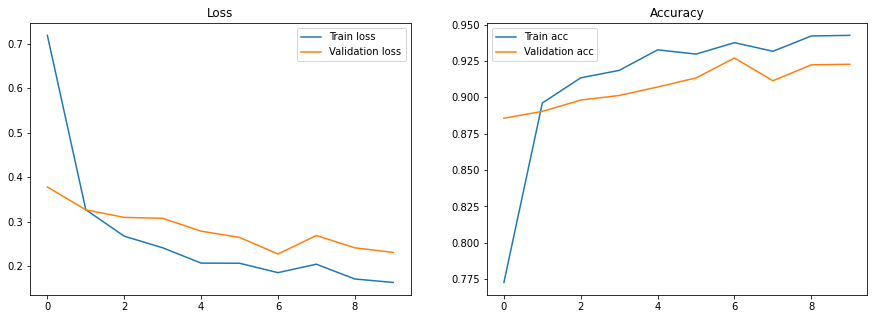

In [40]:
#Plot VVG16 model
show_final_history(model) 

In [43]:
#Evaluate on test data
valid_loss, valid_accuracy = model.evaluate(val_dataset)
test_loss, test_accuracy   = model.evaluate(test_dataset)

81/81 [==============================] - 7s 88ms/step - loss: 0.2682 - accuracy: 0.9102


In [44]:
print('Validation Accuracy: ', round((valid_accuracy * 100), 1), "%")
print('Test Accuracy: ', round((test_accuracy * 100), 1), "%")
print(" ")
print('Validation Loss: ', round(valid_loss, 1))
print('Test Loss: ', round(test_loss, 1))

Validation Accuracy:  90.5 %
Test Accuracy:  91.0 %
 
Validation Loss:  0.3
Test Loss:  0.3


In [45]:
test_steps = test_dataset.n // test_dataset.batch_size
print(test_steps)

80


In [46]:
test_dataset.reset()
X_test_, y_test_true = [],[] 
for i in range(test_steps):
    X , y = next(test_dataset)
    X_test_.extend(X) 
    y_test_true.extend(y)

In [51]:
#Convert to np arrays
X_test_    = np.array(X_test_)
y_test_true= np.array(y_test_true)
print(X_test_.shape, y_test_true.shape)

(2560, 224, 224, 3) (2560, 8)


In [48]:
#Use model to predict test data
y_pred = model.predict(X_test_)

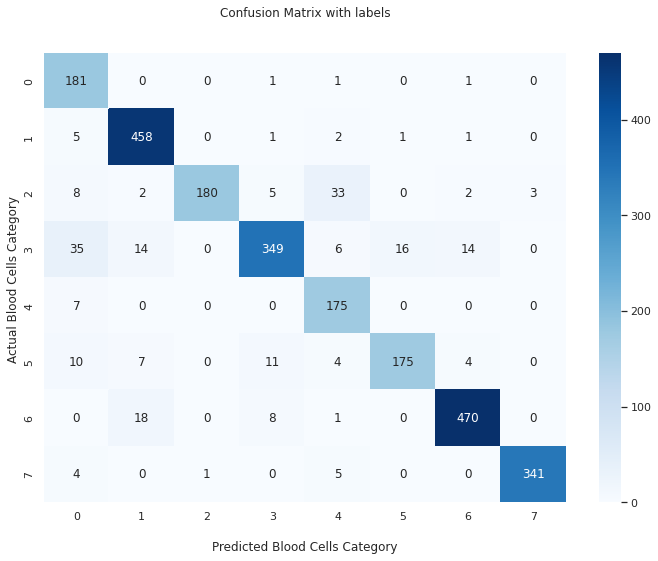

In [58]:
#Plot confusion matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
confusionMatrix = confusion_matrix(np.argmax(y_test_true, axis=1), np.argmax(y_pred, axis=1))

ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Blood Cells Category')
ax.set_ylabel('Actual Blood Cells Category ');

# ax.xaxis.set_ticklabels(classes)
# ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
#Classification report
print(classification_report(np.argmax(y_test_true, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       184
           1       0.92      0.98      0.95       468
           2       0.99      0.77      0.87       233
           3       0.93      0.80      0.86       434
           4       0.77      0.96      0.86       182
           5       0.91      0.83      0.87       211
           6       0.96      0.95      0.95       497
           7       0.99      0.97      0.98       351

    accuracy                           0.91      2560
   macro avg       0.90      0.91      0.90      2560
weighted avg       0.92      0.91      0.91      2560



In [27]:
 #keras.backend.clear_session()